In [ ]:
from google.colab import files, drive
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import zipfile
from tensorflow import keras
import tensorflow as tf 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.datasets import mnist

def load_mnist_dataset():

  # load data from tensorflow framework
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data() 

  # Stacking train data and test data to form single array named data
  data = np.vstack([trainData, testData]) 

  # Vertical stacking labels of train and test set
  labels = np.hstack([trainLabels, testLabels]) 

  # return a 2-tuple of the MNIST data and labels
  return (data, labels)

In [ ]:
def load_az_dataset(datasetPath):

  # List for storing data
  data = []
  
  # List for storing labels
  labels = []
  
  for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
    row = row.split(",")
    
    #row[0] contains label
    label = int(row[0])
    
    #Other all collumns contains pixel values make a saperate array for that
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    
    #Reshaping image to 28 x 28 pixels
    image = image.reshape((28, 28))
    
    #append image to data
    data.append(image)
    
    #append label to labels
    labels.append(label)
    
  #Converting data to numpy array of type float32
  data = np.array(data, dtype='float32')
  
  #Converting labels to type int
  labels = np.array(labels, dtype="int")
  
  return (data, labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(digitsData, digitsLabels) = load_mnist_dataset()

(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/ML BANGKIT/A_Z Handwritten Data.csv')

In [ ]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [ ]:
from sklearn.preprocessing import LabelBinarizer
le = LabelBinarizer()
labels = le.fit_transform(labels)

counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]

In [ ]:
# construct the image generator for data augmentation

aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

In [ ]:
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [ ]:
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

In [ ]:
#split data
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
#jangan di run kalau tidak ingin melakukan trainning model
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=INIT_LR, )

model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
(64, 64, 128, 256), reg=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
aug.flow(x_train, y_train, batch_size=BS),
validation_data=(x_test, y_test),
steps_per_epoch=len(x_train) // BS,epochs=EPOCHS,
class_weight=classWeight,
verbose=1)

Epoch 1/50
2765/2765 [==============================] - 228s 75ms/step - loss: 2.0493 - accuracy: 0.8563 - val_loss: 0.6423 - val_accuracy: 0.8751
Epoch 2/50
2765/2765 [==============================] - 202s 73ms/step - loss: 1.0401 - accuracy: 0.9212 - val_loss: 0.7001 - val_accuracy: 0.8473
Epoch 3/50
2765/2765 [==============================] - 203s 73ms/step - loss: 0.9343 - accuracy: 0.9290 - val_loss: 0.5749 - val_accuracy: 0.8735
Epoch 4/50
2765/2765 [==============================] - 204s 74ms/step - loss: 0.8550 - accuracy: 0.9323 - val_loss: 0.5098 - val_accuracy: 0.8917
Epoch 5/50
2765/2765 [==============================] - 202s 73ms/step - loss: 0.8075 - accuracy: 0.9375 - val_loss: 0.4458 - val_accuracy: 0.9346
Epoch 6/50
2765/2765 [==============================] - 202s 73ms/step - loss: 0.7623 - accuracy: 0.9431 - val_loss: 0.3920 - val_accuracy: 0.9599
Epoch 7/50
2765/2765 [==============================] - 204s 74ms/step - loss: 0.7492 - accuracy: 0.9448 - val_loss: 3

In [ ]:
model.save('OCR_Resnet_dipta.h5')

In [ ]:
model.save_weights("OCR_Resnet_dipta_weight.h5")

In [ ]:
from google.colab import files
files.download('OCR_Resnet_dipta.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model._weights("OCR_Resnet_dipta_weight.h5")

In [ ]:

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/OCR_Resnet_dipta.h5')

In [ ]:
from sklearn.metrics import classification_report #Fungsi ini digunakan untuk menghasilkan laporan klasifikasi yang mencakup berbagai metrik evaluasi seperti akurasi, presisi, recall, dan F1-score.

#Menginisialisasi string labelNames dengan karakter angka dari 0 hingga 9.
labelNames = "0123456789" 

#Menambahkan karakter huruf kapital A hingga Z ke dalam string labelNames.
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ" 

# Mengubah string labelNames menjadi list dengan setiap karakter sebagai elemen dalam list. Hal ini dilakukan untuk memastikan bahwa labelNames berisi daftar label yang dapat diindeks.
labelNames = [l for l in labelNames] 

#Menggunakan model (model) untuk melakukan prediksi pada data uji (x_test). Hasil prediksi disimpan dalam variabel predictions. Parameter batch_size digunakan untuk menentukan ukuran batch saat melakukan prediksi.
predictions = model.predict(x_test, batch_size=BS)

#Mencetak laporan klasifikasi menggunakan fungsi classification_report. Parameter pertama (y_test.argmax(axis=1)) adalah label asli dari data uji yang diubah ke bentuk one-hot encoding dan kemudian diambil argumen terbesar. Parameter kedua (predictions.argmax(axis=1)) adalah hasil prediksi model yang diubah ke bentuk argumen terbesar. Parameter target_names adalah daftar label yang digunakan untuk menampilkan nama kelas dalam laporan.
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) 

692/692 [==============================] - 231s 333ms/step
              precision    recall  f1-score   support

           0       0.95      0.38      0.54      1300
           1       0.98      0.99      0.98      1568
           2       1.00      0.69      0.82      1437
           3       1.00      0.86      0.93      1362
           4       1.00      0.78      0.87      1387
           5       0.91      0.82      0.87      1279
           6       0.99      0.90      0.94      1347
           7       0.99      0.90      0.95      1447
           8       0.99      0.92      0.96      1340
           9       1.00      0.95      0.98      1402
           A       0.99      0.94      0.97      2697
           B       0.93      0.98      0.96      1811
           C       1.00      0.73      0.84      4709
           D       0.65      0.98      0.78      1952
           E       0.53      1.00      0.70      2289
           F       0.97      0.95      0.96       238
           G       0.7

1/1 [==============================] - 0s 21ms/step


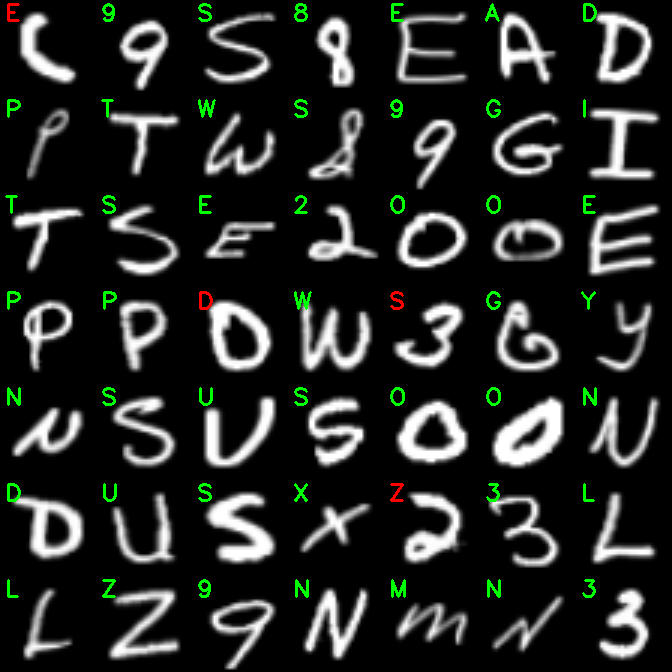

-1

In [ ]:
images = []                                                           #Membuat sebuah list kosong untuk menyimpan gambar yang telah diproses.
# randomly select a few testing characters
from imutils import build_montages                                    #Fungsi ini digunakan untuk membangun montage gambar.
from google.colab.patches import cv2_imshow                           # Fungsi ini digunakan untuk menampilkan gambar dalam lingkungan Google Colab.
output = ""                                                           #Menginisialisasi sebuah string kosong yang akan digunakan untuk menyimpan label prediksi.
for i in np.random.choice(np.arange(0, len(y_test)), size=(49,)):     #Memulai loop yang akan melakukan pengulangan sebanyak 49 kali. Pada setiap iterasi, indeks gambar akan dipilih secara acak dari data uji (y_test).
  probs = model.predict(x_test[np.newaxis, i])                        #Menggunakan model (model) untuk melakukan prediksi pada gambar uji yang dipilih (x_test[i]). np.newaxis digunakan untuk menambahkan dimensi tambahan agar sesuai dengan input model.
  prediction = probs.argmax(axis=1)                                   #Mengambil indeks dengan probabilitas tertinggi dari hasil prediksi (probs). Hal ini akan memberikan prediksi kelas gambar.
  label = labelNames[prediction[0]]                                   #Mengambil label yang sesuai dengan prediksi kelas gambar dari labelNames. prediction[0] menyimpan nilai prediksi kelas gambar sebagai indeks label.
  output+=label                                                       #Menambahkan label ke string output.
  image = (x_test[i] * 255).astype("uint8")                           #Mengubah gambar menjadi tipe data unsigned integer (uint8) dengan mengalikan setiap piksel dengan 255. Hal ini diperlukan karena gambar awalnya dalam rentang 0-1.
  color = (0, 255, 0)                                                 # Menginisialisasi warna awal untuk label prediksi menjadi hijau.
  if prediction[0] != np.argmax(y_test[i]):                           # Jika prediksi tidak cocok dengan label asli (y_test[i]), maka warna diubah menjadi merah.
   color = (0, 0, 255)
  image = cv2.merge([image] * 3)                                      #Menggabungkan gambar dengan dirinya sendiri sebanyak 3 kali pada saluran warna. Hal ini dilakukan agar gambar memiliki 3 saluran warna yang sama untuk visualisasi.
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR) #Meresize gambar menjadi ukuran (96, 96) piksel menggunakan metode interpolasi linear.
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
  color, 2)                                                           #Menambahkan teks label pada gambar menggunakan fungsi putText dari OpenCV. Teks label ditampilkan pada koordinat (5, 20) dengan ukuran font 0.75 dan warna yang sesuai.
  images.append(image)                                                #Menambahkan gambar yang telah diproses ke dalam list images.
  
montage = build_montages(images, (96, 96), (7, 7))[0]                 #Membangun montage gambar menggunakan fungsi build_montages dengan ukuran gambar (96, 96) piksel dan ukuran grid (7, 7). [0] digunakan untuk mengambil montage pertama jika ada beberapa montage yang dibangun.
cv2_imshow(montage)                                                   #Menampilkan montage gambar menggunakan fungsi 
cv2.waitKey(0)                                                        #Menunggu pemakaian tombol sebelum menutup tampilan gambar.

In [ ]:
print(output)

E9S8EADPTWS9GITSE2OOEPPDWSGYNSUSOONDUSXZ3LLZ9NMN3
